In [5]:
include("../src/celerite.jl")
include("../examples/transit.jl")
using Plots
using Unitful
using Statistics

# sets up transit centered at t0 with depth rp and impact parameter b
function setup_transit(t0, rp, b)
    
    Msun = 1.989e30
    Rsun = 6.95e8
    
    P = 50
    Psec = P*24*60*60
    a = (((Psec^2)*Unitful.G.val*Msun*1.04/(4*pi^2))^(1/3))/(1.73*Rsun)
    inc = acos(b/a)*(180/pi) 
    
    xp::Array{Number, 1} = zeros(10)
    xp[1] = P #P  (units of day)
    xp[2] = inc #inc = inclination angle
    xp[3] = rp # R_p/R_* = radius of planet in units of radius of star
    xp[4] = t0 #t0 = mid-point of transit
    xp[5] = 0.1 #u1 = linear limb-darkening coefficient
    xp[6] = 0.0 #u2 = quadratic limb-darkening coefficient
    xp[7] = 1.0 #f0 = uneclipsed flux
    xp[8] = a #a/R_* = semi-major axis divided by R_*
    xp[9] = 0.0 #e = eccentricity
    xp[10] = 90.0 #omega = longitude of pericentre
    return xp
end

# returns a transit light curve with transit parameters transitparams=[t0, rp, b] and variability GP parameters varparams=[log_S0, Q, W0]
function lightcurve(t, varparams, transitparams)
    
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1)
    celerite.compute!(gp, t, varparams[4])
    u = randn(length(t))
    flux = celerite.simulate_gp(gp, u)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    return flux .+ fp
end

function lightcurve2d(t, scales, varparams, transitparams, unmix=true)
    
    Q = broadcast(*, scales, scales')
    n = length(scales)
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1, Q)
    celerite.compute!(gp, t, varparams[4])
    u = randn(length(t)*n)
    y = celerite.simulate_gp(gp, u)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    if unmix
        flux = zeros(n, length(t))
        for i in 1:n
            flux[i,:] = y[i:n:end] .+ fp .- 1
        end
    else
        flux = zeros(length(y))
        for i in 1:n
            flux[i:n:end] .= y[i:n:end] .+ fp
        end
    end
    return flux
end

lightcurve2d (generic function with 2 methods)

In [6]:
# produce 2d data 
t = collect(0:0.001:2)
varparams = [-16.2478, -1.81818, 1.37842, 0.00065]
transitparams = [1, 0.02, 0]
scales = [1, 1.5, 2, 3]
y2d = lightcurve2d(t, scales, varparams, transitparams, false)

plot(size=(1000, 300))
plot!(t, y2d[1:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.01 .+ y2d[2:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.02 .+ y2d[3:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)
plot!(t, 0.03 .+ y2d[4:4:end], markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)

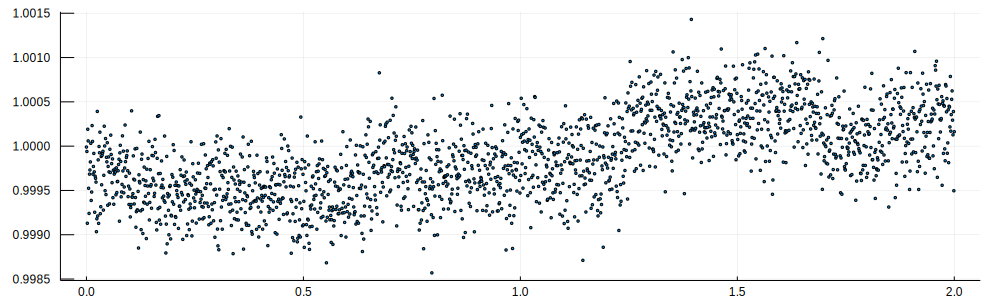

In [26]:
y1d = zeros(length(t))
for i in 1:length(t)
    y1d[i] = mean(y2d[4*(i-1)+1:4*i])
end
plot(size=(1000, 300))
plot!(t, y1d, markershape=:circle, legend=false, markersize=1, linewidth=1, linealpha=0.0)

In [28]:
using Optim

# log likelihood of variability + transit model 
function log_likelihood(t, varparams, transitparams, y)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    y_notransit = y .- fp
    
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1)
    celerite.compute!(gp, t, varparams[4])
    return celerite.log_likelihood(gp, y_notransit)
end

# function to fit light curve y(t) holding depth d constant 
# for t0=5, b=0
function fitlc(t, y, d)
    
    function nll(p)
        varparams = vcat(p[1:3], exp(p[4]))
        transitparams = [1, d, 0.001]
        try
            return -log_likelihood(t, varparams, transitparams, y)
        catch
            println(p)
        end
    end
    
    # initial 
    initial_guess = [-16, -2, 1.5, log(0.0007)]
    upper = 20*ones(4)
    lower = -20*ones(4)
    
    upper[1] = 1
    lower[4] = -10

    res = optimize(nll, lower, upper, initial_guess, Fminbox(BFGS()); autodiff = :forward)
    return res.minimizer, -nll(res.minimizer)
end

function log_likelihood2d(t, scales, varparams, transitparams, y)
    xp = setup_transit(transitparams[1], transitparams[2], transitparams[3])
    fp = transit(t, xp)
    n = length(scales) + 1
    y_notransit::Array{Real} = zeros(length(y))
    for i in 1:n
        y_notransit[i:n:end] .= y[i:n:end] .- fp
    end
    
    scales = vcat([1], scales)
    Q = broadcast(*, scales, scales')
    t1 = celerite.SHOTerm(varparams[1], varparams[2], varparams[3])
    gp = celerite.Celerite(t1, Q)
    celerite.compute!(gp, t, varparams[4])
    return celerite.log_likelihood(gp, y_notransit)
end

function fitlc2d(t, y, n, d)
    
    function nll(p)
        # remember that scales is length n-1
        varparams = vcat(p[n:n+2], exp(p[n+3]))
        transitparams = [1, d, 0.001]
        #try
        return -log_likelihood2d(t, p[1:n-1], varparams, transitparams, y)
        #catch
        #    println(p)
        #end
    end

    # initial 
    initial_guess = vcat(1.1*ones(n-1), [-16, -2, 1.5, log(0.0007)])
    upper = 10*ones(n + 3)
    lower = -20*ones(n + 3)
    
    lower[1:n-1] = ones(n-1)
    upper[1:n-1] = 10*ones(n-1)
    upper[n] = 1
    lower[n + 3] = -10

    res = optimize(nll, lower, upper, initial_guess, Fminbox(BFGS()); autodiff = :forward)
    return res.minimizer, -nll(res.minimizer)
end

# uses Laplace's method to approximate integral over model parameters to get the marginalized likelihood
#function marginalized_likelihood(t, y, d)
#    
#    f(x::Vector) = log_likelihood(t, x, [5, d, 0], y)/length(y)
#    x, maxlike = fitlc(t, y, depths[i])

fitlc2d (generic function with 1 method)

1 best fit parameters: [-16.3065, -1.98333, 2.26858, -8.04363] likelihood: 13214.368188620141
2 best fit parameters: [-16.3015, -1.98366, 2.25822, -8.04368] likelihood: 13214.813673671659
3 best fit parameters: [-16.2946, -1.98415, 2.24699, -8.04374] likelihood: 13215.265465433811
4 best fit parameters: [-16.289, -1.98379, 2.2356, -8.04379] likelihood: 13215.720916028873
5 best fit parameters: [-16.2823, -1.98318, 2.22353, -8.04385] likelihood: 13216.177100684845
6 best fit parameters: [-16.2746, -1.98222, 2.21079, -8.0439] likelihood: 13216.63100710047
7 best fit parameters: [-16.2677, -1.98031, 2.19776, -8.04396] likelihood: 13217.079330388036
8 best fit parameters: [-16.2606, -1.97756, 2.18429, -8.04401] likelihood: 13217.518592225308
9 best fit parameters: [-16.2537, -1.97384, 2.17042, -8.04406] likelihood: 13217.944880858005
10 best fit parameters: [-16.2469, -1.96899, 2.15619, -8.04411] likelihood: 13218.35366942254
11 best fit parameters: [-16.2404, -1.96289, 2.14166, -8.04416] 

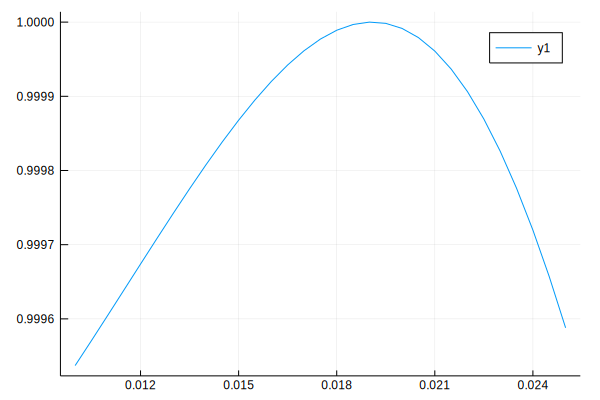

In [50]:
depths = collect(0.01:0.0005:0.025)
like1d = zeros(length(depths))

for i in 1:length(depths)
    res, like1d[i] = fitlc(t, y1d, depths[i])
    println(i, " best fit parameters: ", res, " likelihood: ", like1d[i])
end
plot(depths, like1d/maximum(like1d))

In [ ]:
depths = collect(0.01:0.0005:0.025)
like2d = zeros(length(depths))

for i in 1:length(depths)
    res, like2d[i] = fitlc2d(t, y2d, 4, depths[i])
    println(i, " best fit parameters: ", res, " likelihood: ", like2d[i])
end

1 best fit parameters: [1.34828, 1.81, 2.68657, -17.5043, -1.84764, 2.24948, -7.34808] likelihood: 47412.55026039184
2 best fit parameters: [1.35374, 1.81884, 2.70891, -17.5124, -1.8489, 2.24256, -7.34831] likelihood: 47414.656302669246
3 best fit parameters: [1.35931, 1.8277, 2.73158, -17.5202, -1.85007, 2.23535, -7.34855] likelihood: 47416.80536422828
4 best fit parameters: [1.36496, 1.83651, 2.75438, -17.5278, -1.85109, 2.2279, -7.34879] likelihood: 47418.98598521007
5 best fit parameters: [1.37064, 1.84516, 2.7771, -17.535, -1.85193, 2.22021, -7.34904] likelihood: 47421.185550168135
6 best fit parameters: [1.37632, 1.85355, 2.79952, -17.5416, -1.85253, 2.21229, -7.34928] likelihood: 47423.3904642788
7 best fit parameters: [1.38193, 1.86155, 2.8214, -17.5476, -1.85286, 2.20418, -7.34953] likelihood: 47425.58595206413
8 best fit parameters: [1.38742, 1.86905, 2.84245, -17.5529, -1.85285, 2.19589, -7.34977] likelihood: 47427.75618244166
9 best fit parameters: [1.39272, 1.8759, 2.86238

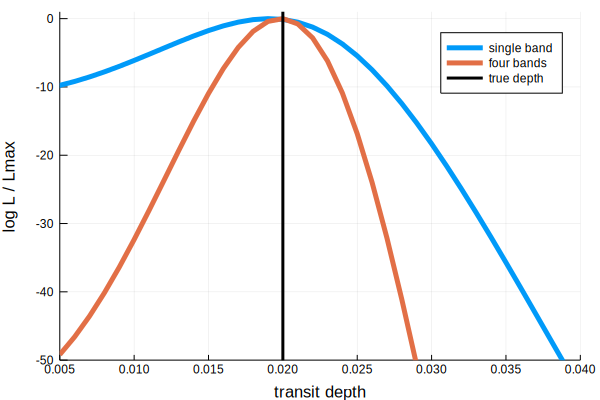

In [32]:
plot(xlims=(0.005, 0.04), ylims=(-50, 1), ylabel="log L / Lmax", xlabel="transit depth")
plot!(collect(0:0.001:0.05), like1d .- maximum(like1d), label="single band", linewidth=5)
plot!(collect(0.005:0.001:0.05), like2d .- maximum(like2d), label="four bands", linewidth=5)
vline!([0.02], linewidth=3, color=:black, label="true depth")

In [41]:
using ForwardDiff
h(x::Real) = log_likelihood(t, [-16.2127, -1.86023, 2.02939, exp(-8.04433)], [1, x, 0.001], y1d)
g(x::Real) = ForwardDiff.derivative(h, x)
x0 = 0.02
second_der = ForwardDiff.derivative(g, x0)
log_A1 = log(sqrt(-second_der/(2*pi))) - log_likelihood(t, [-16.2127, -1.86023, 2.02939, exp(-8.04433)], [1, 0.02, 0.001], y1d)

-13214.984347791373

In [43]:
h(x::Real) = log_likelihood2d(t, [1.4149, 1.85657, 2.89693], [-17.4945, -1.79947, 2.09249, exp(-7.35172)], [1, x, 0.001], y2d)
g(x::Real) = ForwardDiff.derivative(h, x)
x0 = 0.02
second_der = ForwardDiff.derivative(g, x0)
log_A2 = log(sqrt(-second_der/(2*pi))) - log_likelihood2d(t, [1.4149, 1.85657, 2.89693], [-17.4945, -1.79947, 2.09249, exp(-7.35172)], [1, 0.02, 0.001], y2d)

-47438.802602109194

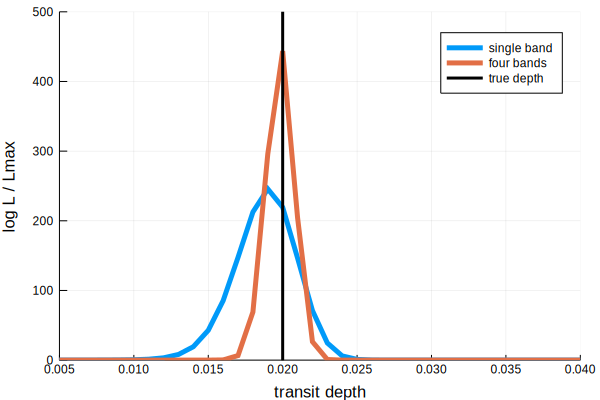

In [49]:
plot(xlims=(0.005, 0.04), ylims=(0, 500), ylabel="log L / Lmax", xlabel="transit depth")
plot!(collect(0:0.001:0.05), exp.(like1d .+ log_A1), label="single band", linewidth=5)
plot!(collect(0.005:0.001:0.05), exp.(like2d .+ log_A2), label="four bands", linewidth=5)
vline!([0.02], linewidth=3, color=:black, label="true depth")